# Chest X-Ray Pneumonia Classification with Vision Transformers
![](https://media.springernature.com/lw685/springer-static/image/art%3A10.1186%2Fs12890-020-01286-5/MediaObjects/12890_2020_1286_Fig2_HTML.png)

The **Vision Transforme**, or ViT, is a model for image classification that employs a Transformer-like architecture over patches of the image. An image is split into fixed-size patches, each of them are then linearly embedded, position embeddings are added, and the resulting sequence of vectors is fed to a standard Transformer encoder. In order to perform classification, the standard approach of adding an extra learnable “classification token” to the sequence is used.

![](https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png)

## **Hugging Face Library**
Hugging Face is a community and data science platform that provides: Tools that enable users to build, train and deploy ML models based on open source code and technologies.

![](https://miro.medium.com/max/1190/1*tAh0R8C8e9EHg3pBuBGoPQ.png)
The following implementation was done with the help of Hugging Face `Transformers` library using Google `vit-base-patch16-224-in21k ` pre-trained model for Fine-tuning.


## Load Dependencies

In [4]:
! pip install transformers -q
! pip install datasets -q

     |████████████████████████████████| 365 kB 7.2 MB/s 
     |████████████████████████████████| 115 kB 35.0 MB/s 
     |████████████████████████████████| 212 kB 60.7 MB/s 
     |████████████████████████████████| 127 kB 72.0 MB/s 


In [5]:
import torch
import os
import shutil
import numpy as np
import pandas as pd
import contextlib
import io
from pathlib import Path
from scipy.special import softmax
import json
import matplotlib.pyplot as plt

#import optimum.graphcore as optimum_graphcore
from torchvision import transforms
import transformers
from transformers import ViTFeatureExtractor
import datasets

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data Loading and Visualization

The used data for training and validation is **Chest X-Ray Pneumonia** available on [Kaggle.](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) 

Dataset will be loaded using Hugging Face datasets package which makes the process much more easier.

In [7]:
from datasets import load_dataset

# Load dataset from drive
ds = load_dataset('imagefolder', data_files = '/content/gdrive/MyDrive/Projects/Chext-X-Ray-Pneumonia-Classiciation-ViT/data.zip')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-0d1b03202a533573/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# Split into train and val
train_val_split = 0.2

split = ds["train"].train_test_split(train_val_split)
ds["train"] = split["train"]
ds["validation"] = split["test"]

In [10]:
# Display data labels
labels = ds['train'].features['label']
labels

ClassLabel(num_classes=2, names=['NORMAL', 'PNEUMONIA'], id=None)

In [11]:
# Take example
ex = ds['train'][400]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1008x584 at 0x7F0B7F424950>,
 'label': 1}

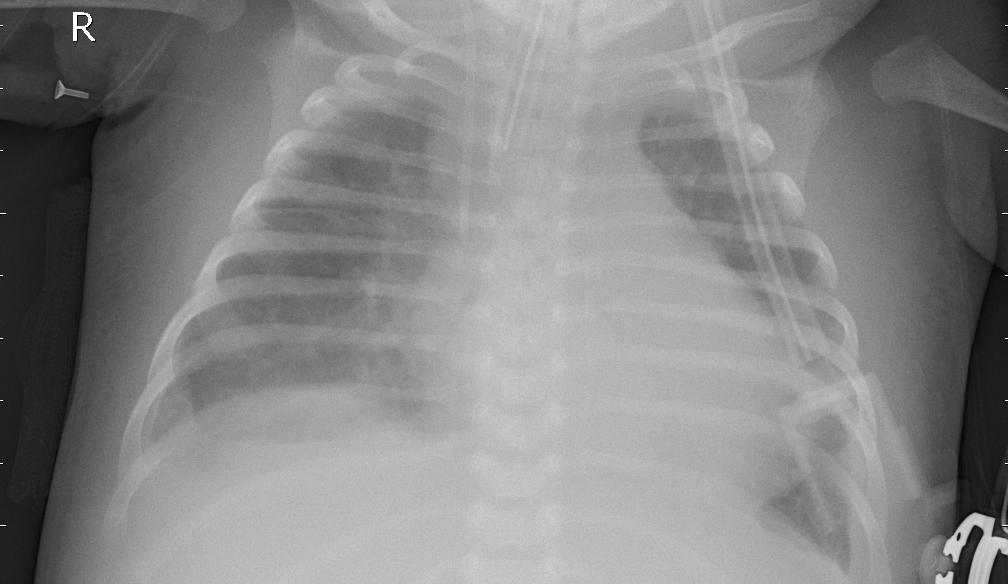

In [12]:
# Display example
image = ex['image']
image

In [13]:
# Show example label
labels.int2str(ex['label'])

'PNEUMONIA'

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

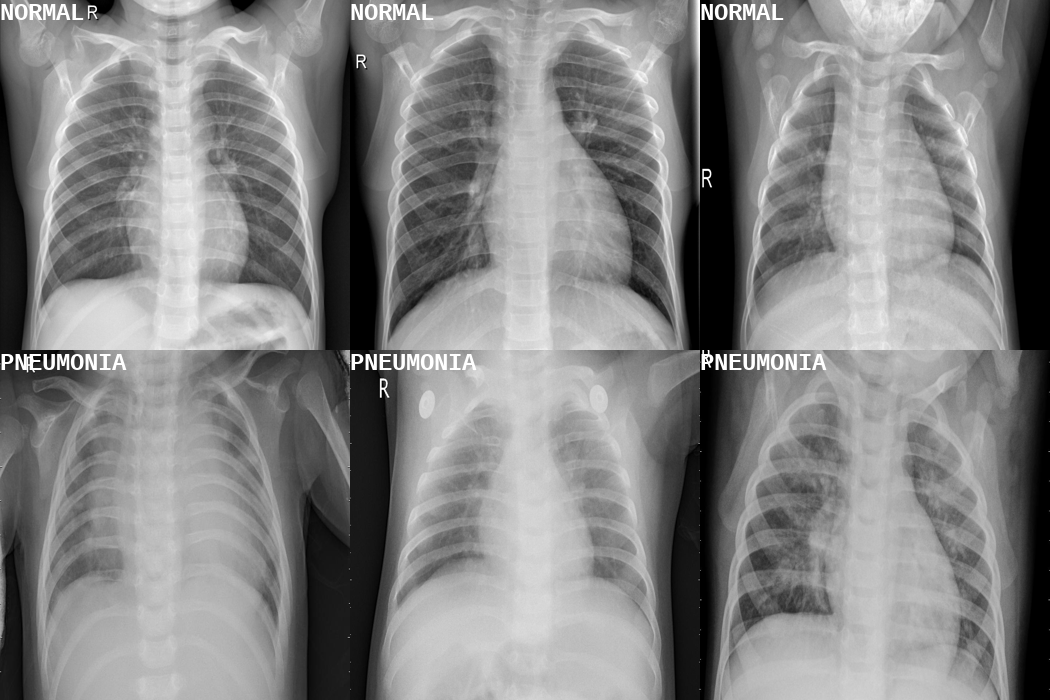

In [14]:
# Visualize sample of dataset
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['label'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

## Data Preprocessing

In [16]:
# Feature extractor model
model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [17]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']
    return inputs

In [18]:
# Preprocess data
prepared_ds = ds.with_transform(transform)

In [22]:
class XRayTransform:
    """
    Transforms for pre-processing XRay data across a batch.
    """
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.Lambda(lambda pil_img: pil_img.convert("RGB")), # Convert to RGB
            transforms.Resize((feature_extractor.size, feature_extractor.size)), # Resize dims
            transforms.ToTensor(), # Convert to tensorfs
            transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std), # Normailize
        ])

    def __call__(self, example_batch):
        example_batch["pixel_values"] = [self.transforms(pil_img) for pil_img in example_batch["image"]]
        return example_batch

In [23]:
# Apply transformation
prepared_ds.set_transform(XRayTransform())

In [24]:
prepared_ds['train'][0:2]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=1968x1688 at 0x7F0B7F751490>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1080x624 at 0x7F0B7F88A990>],
 'label': [1, 1],
 'pixel_values': [tensor([[[-0.5451, -0.5294, -0.5137,  ..., -0.8431, -0.8275, -0.8196],
           [-0.5373, -0.5294, -0.5059,  ..., -0.8510, -0.8431, -0.8353],
           [-0.5137, -0.5059, -0.4902,  ..., -0.8667, -0.8588, -0.8431],
           ...,
           [ 0.2784,  0.2863,  0.3020,  ..., -0.8588, -0.8275, -0.8039],
           [ 0.2627,  0.2941,  0.3098,  ..., -0.8588, -0.8275, -0.7961],
           [ 0.2627,  0.2863,  0.3176,  ..., -0.8510, -0.8275, -0.7961]],
  
          [[-0.5451, -0.5294, -0.5137,  ..., -0.8431, -0.8275, -0.8196],
           [-0.5373, -0.5294, -0.5059,  ..., -0.8510, -0.8431, -0.8353],
           [-0.5137, -0.5059, -0.4902,  ..., -0.8667, -0.8588, -0.8431],
           ...,
           [ 0.2784,  0.2863,  0.3020,  ..., -0.8588, -0.8275, -0.8039],
           [ 0.2627, 

Now, whenever you get an example from the dataset, the transform will be applied in real time (on both samples and slices, as shown below)

## Model Training

In [31]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [32]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [33]:
from transformers import ViTForImageClassification

labels = ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_id,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "NORMAL",
    "1": "PNEUMONIA"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NORMAL": "0",
    "PNEUMONIA": "1"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.22.0"
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d327

In [34]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

PyTorch: setting up devices


In [35]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [36]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** Running training *****
  Num examples = 4438
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1112


Step,Training Loss,Validation Loss,Accuracy
100,0.172000,0.116220,0.959459
200,0.229200,0.122258,0.959459
300,0.105700,0.111943,0.961261
400,0.095300,0.156240,0.943243
500,0.084900,0.090782,0.970270
600,0.064200,0.126661,0.961261
700,0.036900,0.107033,0.973874
800,0.055900,0.090977,0.970270
900,0.070300,0.076839,0.978378
1000,0.007200,0.096861,0.976577


***** Running Evaluation *****
  Num examples = 1110
  Batch size = 8
Saving model checkpoint to ./vit-base-beans/checkpoint-100
Configuration saved in ./vit-base-beans/checkpoint-100/config.json
Model weights saved in ./vit-base-beans/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./vit-base-beans/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1110
  Batch size = 8
Saving model checkpoint to ./vit-base-beans/checkpoint-200
Configuration saved in ./vit-base-beans/checkpoint-200/config.json
Model weights saved in ./vit-base-beans/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./vit-base-beans/checkpoint-200/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1110
  Batch size = 8
Saving model checkpoint to ./vit-base-beans/checkpoint-300
Configuration saved in ./vit-base-beans/checkpoint-300/config.json
Model weights saved in ./vit-base-beans/checkpoint-300/pytorch_model.bin
Feature extractor saved i

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 1281162537GF
  train_loss               =       0.0824
  train_runtime            =   0:15:03.57
  train_samples_per_second =       19.646
  train_steps_per_second   =        1.231


In [37]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 1110
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9784
  eval_loss               =     0.0768
  eval_runtime            = 0:00:26.41
  eval_samples_per_second =     42.026
  eval_steps_per_second   =      5.263


In [39]:
model.save_pretrained('/content/gdrive/MyDrive/Projects/Chext-X-Ray-Pneumonia-Classiciation-ViT')

Configuration saved in /content/gdrive/MyDrive/Projects/Chext-X-Ray-Pneumonia-Classiciation-ViT/config.json
Model weights saved in /content/gdrive/MyDrive/Projects/Chext-X-Ray-Pneumonia-Classiciation-ViT/pytorch_model.bin
